In [19]:
import csv
import joblib
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")


from hmmlearn import hmm

from hmmlearn.hmm import GaussianHMM,GMMHMM,MultinomialHMM
import matplotlib.pyplot as plt


# 状态个数
N = 8
# 最大似然概率阈值
T = -50

# 处理域名的最小长度
MIN_LEN = 10


#模型文件名
FILE_MODEL = "hmm_dga.m"



ALEXA_FILE_PATH = "/home/yhk/jupyter-notebook/data/alexa-top-1m.csv"
DGA_PATH = "/home/yhk/jupyter-notebook/data/DGA/360_netlab_dga.txt"

def load_data(filename,sep=',',nrows=1000,index=1):
    """
        加载数据到列表中
        Parameters:
        --------------------------------
            filename: 文件位置
            sep：csv文件分隔符
            nrows: 加载的行数
            index: 域名处在的列索引
    """
    print(filename)
    domain_list = []
    csv_reader = csv.reader(open(filename),delimiter=sep)
    for row in csv_reader:
        # 只加载nrows行domain进行hmm训练
        if len(domain_list)==nrows:
            break
        domain = row[index]
        if len(domain) >= MIN_LEN:
            domain_list.append(domain)
    return domain_list

def get_sld(domain):
    """
        获取域名的二级域名
    """
    return domain.split(".")[-2]


def domain2vec(domain):
    """
        域名转化为向量
    """
    vec = []
    for i in range(0, len(domain)):
        vec.append([ord(domain[i])])
    return vec


class DGA_hmm():
    
    def __init__(self,model_file=None):
        if model_file==None:
            self.model = hmm.GaussianHMM(n_components=N, covariance_type="full", n_iter=100)
        else:
            self.model = self.load(model_file)
            
    def load_model(self,model_file):
        return joblib.load(model_file)
        

    def train(self,domain_list):
        """
            模型训练
        """
        X = [[0]]
        X_lens = [1]
        for domain in domain_list:
            vec = domain2vec(get_sld(domain))
            np_vec = np.array(vec)
            X = np.concatenate([X, np_vec])
            X_lens.append(len(np_vec))
        print(self.model)
        self.model.fit(X, X_lens)
        # 存储模型
        joblib.dump(self.model, FILE_MODEL)
        print('model have been saved')

        return self.model

    def predict(self,domain_list):
        """
            使用训练好的模型进行预测
            Parameters:
            ----------------------------------
                filename: 文件位置
                sep：csv文件分隔符
                nrows: 加载的行数
                index: 域名处在的列索引
            Return:
            ----------------------------------
                x: 域名长度
                y: 域名与预测的分数，分数越低越有可能是异常
        """
        x = []
        y = []
        for domain in domain_list:
            domain_vec = domain2vec(get_sld(domain))
            np_vec = np.array(domain_vec)
            pro = self.model.score(np_vec)
            x.append(len(domain))
            y.append(pro)

        return x, y

/home/yhk/jupyter-notebook/data/alexa-top-1m.csv
GaussianHMM(algorithm='viterbi', covariance_type='full', covars_prior=0.01,
      covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
      min_covar=0.001, n_components=8, n_iter=100, params='stmc',
      random_state=None, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
      verbose=False)
model have been saved
/home/yhk/jupyter-notebook/data/DGA/360_netlab_dga.txt


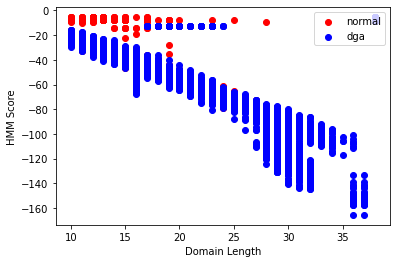

In [20]:
# 训练
model = DGA_hmm()
train_domain_list = load_data(ALEXA_FILE_PATH,nrows=1000)
model.train(train_domain_list)
# 预测
dga_domain = load_data(DGA_PATH,sep='\t',nrows=10000)

x_1, y_1 = model.predict(train_domain_list)
x_2, y_2 = model.predict(dga_domain)

# 预测结果可视化
fig, ax = plt.subplots()
ax.set_xlabel('Domain Length')
ax.set_ylabel('HMM Score')
ax.scatter(x_1, y_1, color='r', label="normal")
ax.scatter(x_2, y_2, color='b', label="dga")
ax.legend(loc='upper right')
plt.show()